In [ ]:
import os
import numpy as np
from typing import Union
import cv2
import matplotlib.pyplot as plt
import glob as glob
import json
import pandas as pd
from PIL import Image
import keras

In [ ]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, SeparableConv2D,Concatenate,Conv2DTranspose, Add, UpSampling2D, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, MaxPool2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img


from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical 

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('drive/MyDrive/xray_lung')
os.getcwd()

'/content/drive/MyDrive/xray_lung'

In [ ]:
image_path = 'Montgomery/CXR_png'
left_seg_path = 'Montgomery/ManualMask/leftMask'
right_seg_path = 'Montgomery/ManualMask/rightMask'

In [ ]:
# import shutil
# temp = glob.glob('Montgomery/CXR_png/*png')
# temp.sort()
# temp = temp[:int(len(temp)*0.8)]
# for file in temp:
#   print(os.path.basename(file))
#   dest = 'Montgomery/CXR_png/train/img'
#   shutil.copyfile(file, f'{dest}/{os.path.basename(file)}')


In [ ]:
img_size = (512,512)
classes = ['lung']
num_classes = len(classes)
batch_size = 4

In [ ]:
# if not os.path.exists('Mongomery/Masks'):
#   os.makedirs('Montgomery/Masks')

In [ ]:
# right_paths = glob.glob(f'{right_seg_path}/*png')
# left_paths = glob.glob(f'{left_seg_path}/*png')
# for index,file in enumerate(right_paths):
#   print(os.path.basename(file))
#   left = load_img(left_paths[index], target_size=img_size, color_mode="grayscale")
#   right = load_img(right_paths[index], target_size=img_size, color_mode="grayscale")

#   img = Image.fromarray((np.array(left) + np.array(right))/255.).convert('RGB')
  
#   img.save(f'Montgomery/Masks/{os.path.basename(file)}', "PNG")
  # plt.imshow(img)
  # plt.show()


In [ ]:
os.getcwd()

'/content/drive/MyDrive/xray_lung'

(4020, 4892)


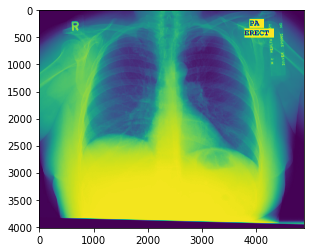

In [ ]:
index = 0
train_img_path = glob.glob('Montgomery/CXR_png/train/img/*png')
img = cv2.imread(train_img_path[index], 0)
# print(np.unique(img, return_counts = True))
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
image_paths = glob.glob('Montgomery/CXR_png/*.png')
target_paths = glob.glob('Montgomery/Masks/*.png')
image_paths.sort()
target_paths.sort()
train_ratio = 0.8
train_input_img_paths = image_paths[:int(len(image_paths) * 0.8)]
val_input_img_paths = [x for x in image_paths if x not in train_input_img_paths]
train_target_img_paths = target_paths[:int(len(target_paths) * 0.8)]
val_target_img_paths = [x for x in target_paths if x not in train_target_img_paths]

print(len(train_target_img_paths))
print(len(val_target_img_paths))

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self,train_im_path = train_input_img_paths,train_mask_path = train_target_img_paths,
                 augmentations = None,img_size = img_size[0],batch_size = 4,nchannels = 3,shuffle = True):
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.nchannels = nchannels
        self.shuffle = shuffle
        self.augmentations = augmentations
        self.on_epoch_end()
    
    def __len__(self):
        
        return int(np.ceil(len(self.train_im_path)/ self.batch_size))
    
    def __getitem__(self,index):
        
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.train_im_path))]
        list_im_ids = [self.train_im_path[i] for i in indexes]
        list_mask_ids = [self.train_mask_path[i] for i in indexes]
        X,y = self.data_generation(list_im_ids,list_mask_ids)
        
        return X,to_categorical(y, num_classes = 2)
    
    def on_epoch_end(self):
        # print(type(self.train_im_path))
        self.indexes = np.arange(len(self.train_im_path))
        if(self.shuffle):
            np.random.shuffle(self.indexes)
    
    def data_generation(self,list_im_ids,list_mask_ids):
        X = np.empty((len(list_im_ids),self.img_size,self.img_size,self.nchannels))
        y = np.empty((len(list_mask_ids),self.img_size,self.img_size,1))
        for i,(img_path, mask_path) in enumerate(zip(list_im_ids,list_mask_ids)):
            mask = np.array(Image.open(mask_path).convert('L'))
            img = np.array(Image.open(img_path))/255
            if(len(img.shape) == 2):
                img = np.repeat(img[...,np.newaxis],3,2)
            
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[...,np.newaxis]
        return np.float32(X),np.float32(y)



train_gen = DataGenerator()
val_gen = DataGenerator(train_im_path = val_input_img_paths, train_mask_path = val_target_img_paths)

110
28


In [ ]:
len(val_gen)

7

In [ ]:
# image_paths = glob.glob('Montgomery/CXR_png/*.png')
# target_paths = glob.glob('Montgomery/Masks/*.png')
# image_paths.sort()
# target_paths.sort()
# train_ratio = 0.8
# train_input_img_paths = image_paths[:int(len(image_paths) * 0.8)]
# val_input_img_paths = [x for x in image_paths if x not in train_input_img_paths]
# train_target_img_paths = target_paths[:int(len(target_paths) * 0.8)]
# val_target_img_paths = [x for x in target_paths if x not in train_target_img_paths]

# print(len(train_target_img_paths))
# print(len(val_target_img_paths))

In [ ]:

# train_gen = ImageDataGen(
#     batch_size, img_size, train_input_img_paths, train_target_img_paths
# )
# val_gen = ImageDataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
# # we create two instances with the same arguments
# data_gen_args = dict(zoom_range=[0.8, 1.2],
#                      horizontal_flip = True,
#                      rotation_range = 10,
#                      featurewise_center=False,
#                       featurewise_std_normalization=False,
#                      )
# # def train_generator( 
# #                     train_path, 
# #                     image_folder = 'Montgomery/CXR_png/train', 
# #                     mask_folder, 
# #                     aug_dict = data_gen_args,
# #                     batch_size = batch_size,
# #         image_color_mode="grayscale",
# #         mask_color_mode="grayscale",
# #         image_save_prefix="image",
# #         mask_save_prefix="mask",
# #         save_to_dir=None,
# #         target_size=img_size,
# #         seed=1):
# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
# # Provide the same seed and keyword arguments to the fit and flow methods
# seed = 1

# image_generator = image_datagen.flow_from_directory(
#   'Montgomery/CXR_png/train',
#   class_mode=None,
#   batch_size = batch_size,
#   target_size=img_size,
#   seed=seed)
# mask_generator = mask_datagen.flow_from_directory(
#   'Montgomery/Masks/train',
#   class_mode=None,
#   batch_size = batch_size,
#   color_mode = 'grayscale',
#   target_size=img_size,
#   seed=seed)
# # combine generators into one which yields image and masks
# train_gen = zip(image_generator, mask_generator)

In [ ]:
# valid_image_datagen = ImageDataGenerator()
# valid_mask_datagen = ImageDataGenerator()
# valid_image_generator = valid_image_datagen.flow_from_directory(
#     'Montgomery/CXR_png/valid',
#     class_mode=None,
#     target_size=img_size,
#     batch_size = batch_size,
#     seed=seed)
# valid_mask_generator = valid_mask_datagen.flow_from_directory(
#     'Montgomery/Masks/valid',
#     class_mode=None,
#     batch_size = batch_size,
#     target_size=img_size,
#     color_mode = 'grayscale',
#     seed=seed)
# # combine generators into one which yields image and masks
# val_gen = zip(valid_image_generator, valid_mask_generator)

In [ ]:
from image_segmentation.keras_segmentation.models.unet import unet_mini

model = unet_mini(n_classes=2,  input_height=img_size[0], input_width=img_size[1]  )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
# # new_layer = model.layers[-1]
# # required_output = model.layers[-4].output
# top_layer = UpSampling2D()(required_output)
# top_layer = Conv2D(2, (1, 1),  activation="softmax", data_format='channels_last')(top_layer)
# # print(new_layer)
# # print(new_model)


# new_model = Model(model.input, top_layer)
# new_model.summary()

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# values = compute_class_weight('balanced',
#                                                  np.unique(np.argmax(target_train, axis = -1).tolist()),
#                                                  np.ravel(np.argmax(target_train, axis = -1)).tolist())

# # class_weight = dict(zip([x for x in range(len(classes))], values))
# sample_weight = values
# sample_weight 

In [ ]:
# import tensorflow.keras as K
# import tensorflow as tf
# def weighted_categorical_crossentropy(weights = class_weight):
#     # weights = [0.9,0.05,0.04,0.01]
#     def wcce(y_true, y_pred):
#         Kweights = K.initializers.constant(weights)
#         if not tf.is_tensor(y_pred): y_pred =  K.initializers.constant(y_pred)
#         y_true = tf.cast(y_true, y_pred.dtype)
#         return K.losses.categorical_crossentropy(y_true, y_pred) * K.backend.sum(y_true * Kweights, axis=-1)
#     return wcce

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
# callback = EarlyStopping(monitor='val_categorical_accuracy', mode = 'max', patience=5)
checkpoint_folderpath = f'weights/{model.model_name}_first_temp'
if not os.path.exists(checkpoint_folderpath):
    os.makedirs(checkpoint_folderpath) 

checkpoint_filepath = checkpoint_folderpath + "/{epoch:02d}-{val_categorical_accuracy:.2f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=f'{checkpoint_filepath}',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

keras_callbacks   = [
      EarlyStopping(monitor='val_categorical_accuracy', patience=7, mode='max', min_delta = 0.01),
      model_checkpoint_callback
]
# loss = weighted_categorical_crossentropy(class_weight)
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef, 'categorical_accuracy'], loss_weights=None,
    weighted_metrics=None, run_eagerly=None)
history = model.fit(
    train_gen,
    # batch_size = batch_size,
    steps_per_epoch=27,
    epochs=25,
#     class_weight = class_weight,
#     sample_weight=sample_weight,
    validation_data = val_gen,
    validation_steps = 7,
    verbose = 1,
    callbacks = keras_callbacks,)

Epoch 1/25
27/27 [==============================] - 103s 4s/step - loss: 0.1860 - dice_coef: 0.8140 - categorical_accuracy: 0.6253 - val_loss: 0.1496 - val_dice_coef: 0.8504 - val_categorical_accuracy: 0.7473
Epoch 2/25
27/27 [==============================] - 100s 4s/step - loss: 0.1447 - dice_coef: 0.8553 - categorical_accuracy: 0.7461 - val_loss: 0.1321 - val_dice_coef: 0.8679 - val_categorical_accuracy: 0.7473
Epoch 3/25
27/27 [==============================] - 100s 4s/step - loss: 0.1151 - dice_coef: 0.8849 - categorical_accuracy: 0.7470 - val_loss: 0.1107 - val_dice_coef: 0.8893 - val_categorical_accuracy: 0.7473
Epoch 4/25
27/27 [==============================] - 101s 4s/step - loss: 0.1069 - dice_coef: 0.8931 - categorical_accuracy: 0.7326 - val_loss: 0.1223 - val_dice_coef: 0.8777 - val_categorical_accuracy: 0.7473
Epoch 5/25
27/27 [==============================] - 101s 4s/step - loss: 0.0877 - dice_coef: 0.9123 - categorical_accuracy: 0.7456 - val_loss: 0.1391 - val_dice_coe

In [ ]:
# callback = EarlyStopping(monitor='val_categorical_accuracy', mode = 'max', patience=5)
checkpoint_folderpath = f'weights/{model.model_name}_first_temp'
if not os.path.exists(checkpoint_folderpath):
    os.makedirs(checkpoint_folderpath) 

checkpoint_filepath = checkpoint_folderpath + "/{epoch:02d}-{val_binary_accuracy:.2f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=f'{checkpoint_filepath}',
    save_weights_only=True,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

keras_callbacks   = [
      EarlyStopping(monitor='val_binary_accuracy', patience=7, mode='max', min_delta = 0.01),
      model_checkpoint_callback
]
# loss = weighted_categorical_crossentropy(class_weight)
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'], loss_weights=None,
    weighted_metrics=None, run_eagerly=None)
history = model.fit(
    train_gen,
    # batch_size = batch_size,
    steps_per_epoch=27,
    epochs=25,
#     class_weight = class_weight,
#     sample_weight=sample_weight,
    validation_data = val_gen,
    validation_steps = 7,
    verbose = 1,
    callbacks = keras_callbacks,)

In [ ]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
ax1.plot(history.history['binary_accuracy'])
ax1.plot(history.history['val_binary_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
weight_files = glob.glob(f'{checkpoint_folderpath}/*h5')
print(weight_files[-1])
model.load_weights(weight_files[-1])

#Wiping remaining weight files
for file in weight_files[:-1]:
    os.remove(file)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    #cm output from sklearn.confusion_matrix
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.round(cm[i, j], 2),
                          ha="center", va="center", color="k")
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def evaluate(y_truth, y_pred, labels): 
    print('Classification Report')
    print(classification_report(y_truth, y_pred,labels = [x for x in range(len(labels))], target_names=labels))
    print('Confusion Matrix')
    plot_confusion_matrix(confusion_matrix(y_truth, y_pred, normalize = 'true'), labels = labels)

In [ ]:
# from evaluate import evaluate
#Ground truth
y_truth = valid_mask_generator.classes
print(y_truth.shape)
print('True Valid',np.unique(y_truth, return_counts = True))

#Predict
predict = model.predict_generator(test_generator,steps = nb_samples)
y_pred = model.predict(data_valid)
y_pred = np.ravel(np.argmax(y_pred, axis = -1))
print(y_pred.shape)
print('Pred Valid', np.unique(y_pred, return_counts = True))


In [ ]:
#Evaluate
evaluate(y_truth, y_pred, classes)